In [1]:
#package
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from WindPy import w
# follow 20241118-上海申银万国证券研究所-数说资产配置系列之十一：盈利、情绪和需求预期：市场信息对宏观量化模型的修正
# follow 20250609-上海申银万国证券研究所-全天候策略再思考：多资产及权益内部的应用实践

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2024 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

# 主成分分析

In [3]:
'''
stock:
沪深300 - 000300.SH
中证500 - 000905.SH
中证1000 - 000852.SH

跨境股票:
标普500 - SPX.GI

债券:
中债7-10年政策性金融债 - CBA08202.CS
中债1-3年国债 - 931552.CSI

商品或其他:
黄金(Au9999) - AU9999.SGE
大商所豆粕期货 - M.DCE
华夏中国交建REIT - 508018.SH #剔除
'''
# 全收益
# investment_pool = ['H00300.CSI','H00905.CSI','H00852.SH','SPX.GI','CBA08202.CS','931552.CSI','AU9999.SGE','M.DCE']
#不考虑分红
investment_pool = ['000300.SH','000905.SH','000852.SH','SPX.GI','CBA08202.CS','931552.CSI','AU9999.SGE','M.DCE']
str = ','.join(investment_pool)
history_data=w.wsd(str,
                   "pct_chg", 
                   "2011-01-01", 
                   "2025-9-30",  
                   'Period=M',    
                   usedf=True) 
price_data = history_data[1]
price_data.to_csv('D:/program_learning/GD_security_working/asset_alloc/price_data/micro_research_price_data.csv')
ret_data = pd.read_csv('D:/program_learning/GD_security_working/asset_alloc/price_data/micro_research_price_data.csv',index_col=0,parse_dates=True)
ret_data.dropna(inplace=True)
ret_data = ret_data/100

In [ ]:
# ret_data = price_data.pct_change().iloc[1:]
cum12_ret_data= ret_data.rolling(window=12).apply(lambda x: (1+x).prod()-1).iloc[11:].loc[:"2021-01-01"]
cum12_ret_data

,000300.SH,000905.SH,000852.SH,SPX.GI,CBA08202.CS,931552.CSI,AU9999.SGE,M.DCE
2012-12-31,0.075545,0.002781,-0.014317,0.134057,-0.031529,0.025015,0.062335,0.110132
2013-01-31,0.090340,0.056198,0.068253,0.141495,-0.032608,0.026480,-0.037330,0.191981
2013-02-28,0.014875,-0.023794,-0.011098,0.109103,-0.010973,0.029145,-0.096238,0.067240
2013-03-29,0.016369,0.008906,0.042616,0.114110,-0.006103,0.026989,-0.046452,-0.004624
2013-04-26,-0.068104,-0.081010,-0.054817,0.142828,0.014434,0.028775,-0.109356,-0.051719
...,...,...,...,...,...,...,...,...
2025-05-30,0.072713,0.068292,0.125364,0.120167,0.040330,0.022887,0.391670,-0.150787
2025-06-30,0.137051,0.196773,0.298243,0.136338,0.033406,0.021703,0.393761,-0.122407
2025-07-31,0.184047,0.274215,0.362462,0.147962,0.019479,0.018704,0.367228,-0.030068
2025-08-29,0.353861,0.518381,0.606862,0.143733,0.016213,0.019017,0.371003,0.009250


In [52]:
cum12_ret_data_standardize = (cum12_ret_data - cum12_ret_data.mean()) / cum12_ret_data.std()

In [53]:
from Util_Fin.PCAanalysis import PCAAnalyzer
import matplotlib.pyplot as plt
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

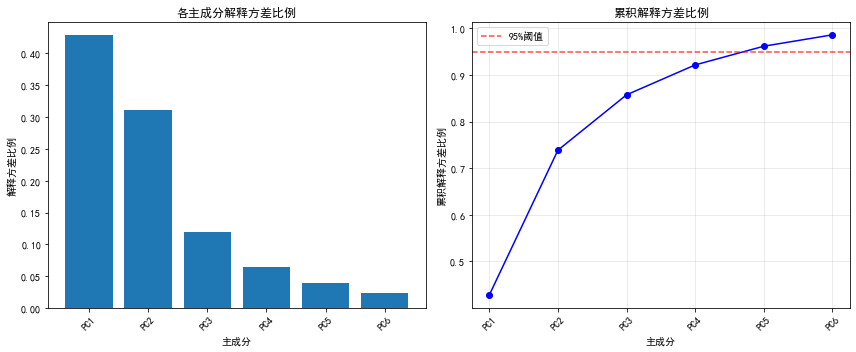

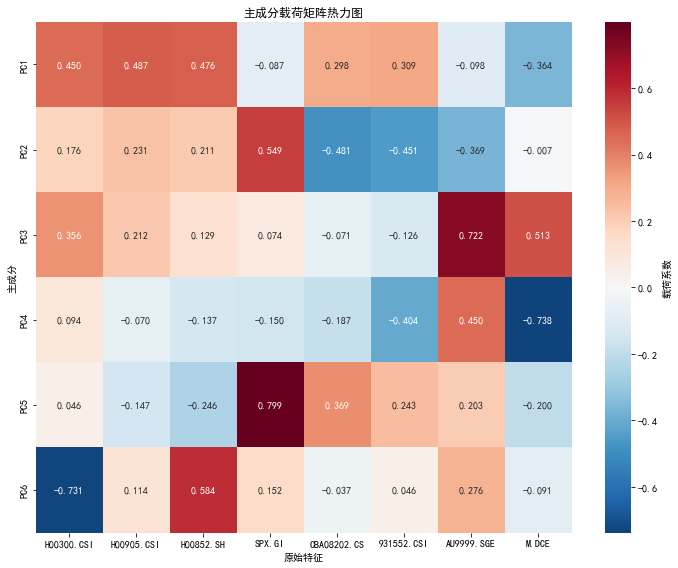

In [54]:
pca_analyzer = PCAAnalyzer(standardize=True,n_components=6)
pca_analyzer.fit(cum12_ret_data_standardize)

# 获取分析结果
summary = pca_analyzer.get_summary_statistics()
components = pca_analyzer.get_components_matrix()

# 可视化
pca_analyzer.plot_explained_variance()
pca_analyzer.plot_components_heatmap()


In [43]:
pca_ret = pd.DataFrame(pca_analyzer.transform(),index=cum12_ret_data_standardize.index)
pca_ret.to_csv("pca_series.csv")
pca_ret

,0,1,2,3,4,5
2012-12-31,-1.132769,0.449141,0.585723,-0.115491,-0.177131,-0.152981
2013-01-31,-1.052218,0.782539,0.508434,-0.915177,-0.408951,-0.246012
2013-02-28,-0.830294,0.293328,-0.467214,-0.496496,-0.351944,-0.294974
2013-03-29,-0.580065,0.297108,-0.442609,0.029686,-0.194921,-0.069341
2013-04-26,-0.698499,0.228760,-1.114977,-0.044057,0.324984,-0.075432
...,...,...,...,...,...,...
2020-08-31,0.482124,0.980672,1.474235,0.389256,0.459633,0.521515
2020-09-30,-0.051830,0.426675,1.356400,0.255652,-0.170384,0.251535
2020-10-30,0.025704,-0.041460,1.263207,0.238932,-0.591074,0.066571
2020-11-30,-0.070209,0.835710,1.627952,-0.402413,-0.184849,-0.062162


# 宏观数据获取

In [ ]:
'''
获取宏观数据
经济:  工业增加值当月同比的滚动 3 个月平均 # M0061675-Wind一致预期 
                                         # M0000545-规模以上工业企业增加值当月同比 *
流动性: 10 年期国债到期收益率  # S0059749-中债10年期国债到期收益率 *  
                              # M1001654-中国10年期国债到期收益率
通胀: CPI同比  # M0061676-Wind一致预期CPI同比 
              # M0000612-CPI当月同比 * 
通胀: PPI同比 # M0061677-Wind一致预期PPI同比 
              # M0001227-PPI当月同比 * 
信用: 累计12个月新增社融同比增速 # M5206731 社融:新增人民币贷款 /del
                            # M5206732 社融:新增外币贷款 /del
                            # M5206733 社融:新增委托贷款  /del
                            # M5206734 社融:新增信托贷款 /del
                            # M5206735 社融:新增未贴现银行汇票 /del
                            # M5206730 社融:当月值
'''


'\n获取宏观数据\n经济:  工业增加值当月同比的滚动 3 个月平均 # M0061675-Wind一致预期 # M0000545-规模以上工业企业增加值当月同比 *\n流动性: 10 年期国债到期收益率  # S0059749-中债10年期国债到期收益率 *  # M1001654-中国10年期国债到期收益率\n通胀: CPI同比  # M0061676-Wind一致预期CPI同比 # M0000612-CPI当月同比 * \n通胀: PPI同比 # M0061677-Wind一致预期PPI同比 # M0001227-PPI当月同比 * \n信用: 累计12个月新增社融同比增速 # M5206731 社融:新增人民币贷款 \n                            # M5206732 社融:新增外币贷款 \n                            # M5206733 社融:新增委托贷款 \n                            # M5206734 社融:新增信托贷款\n                            # M5206735 社融:新增未贴现银行汇票\n'

In [ ]:
# 1.关于GDP
macro_data = w.edb("M0061675,M0000545,S0059749,M1001654,M0061676,M0000612,M0061677,M0001227,M5206730",
                   "2009-01-01",
                   "2025-10-27",
                   "Fill=Previous",
                   'Period=M',
                   usedf=True)
macro_data = macro_data[1]
macro_data.to_csv("D:/program_learning/GD_security_working/asset_alloc/price_data/macro_social_data.csv")
macro_data = pd.read_csv("D:/program_learning/GD_security_working/asset_alloc/price_data/macro_social_data.csv", index_col=0,parse_dates=True)
macro_data = macro_data.resample('M').last().dropna().loc[:'2021-01-01']
# macro_data.resample("Y").count()

In [ ]:
macro_data['新增社融'] = macro_data['M5206730']
macro_data['S0059749'] = 1/macro_data['S0059749']
macro_data['累计12个月新增社融'] = macro_data['新增社融'].rolling(12).sum()
macro_data['累计12个月新增社融同比增速'] = macro_data['累计12个月新增社融'].pct_change(12)*100
macro_data['工业增加值同比增速三月平均'] = macro_data['M0000545'].rolling(3).mean()

In [16]:
macro_data.loc["2012-12-01":]

,M0061675,M0000545,S0059749,M1001654,M0061676,M0000612,M0061677,M0001227,M5206730,新增社融,累计12个月新增社融,累计12个月新增社融同比增速,工业增加值同比增速三月平均
2012-12-31,10.13,10.3,0.279814,3.5750,2.36,2.5000,-1.85,-1.94,16282.0,16282.0,157632.000000,0.228755,10.000000
2013-01-31,10.13,17.7,0.277362,3.6024,1.92,2.0305,-1.67,-1.64,25446.0,25446.0,173324.000000,0.438612,12.700000
2013-02-28,10.41,2.2,0.278110,3.5996,2.93,3.2198,-1.62,-1.63,10705.0,10705.0,173598.000000,0.395000,10.066667
2013-03-31,10.03,8.9,0.282550,3.5505,2.41,2.0696,-1.85,-1.92,25503.0,25503.0,180397.000000,0.443927,9.600000
2013-04-30,9.67,9.3,0.291426,3.4331,2.27,2.3861,-2.25,-2.62,17629.0,17629.0,188389.000000,0.558235,6.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,5.38,5.6,0.331378,3.0281,2.41,2.4000,-1.97,-2.00,35853.0,35853.0,337237.128810,0.354364,5.066667
2020-09-30,5.82,6.9,0.317642,3.1574,1.81,1.7000,-1.65,-2.10,34693.0,34693.0,346787.918354,0.381177,5.766667
2020-10-31,6.48,6.9,0.314367,3.1898,0.75,0.5000,-2.07,-2.10,13929.0,13929.0,352036.916232,0.406889,6.466667
2020-11-30,6.72,7.0,0.307692,3.2425,0.06,-0.5000,-1.46,-1.50,21355.0,21355.0,353455.000000,0.391372,6.933333


In [12]:
macro_data_cal = macro_data[['工业增加值同比增速三月平均','S0059749','M0000612','M0001227', '累计12个月新增社融同比增速']]
macro_data_cal.columns = ['工业增加值同比增速三月平均','10年期国债到期收益率','CPI同比','PPI同比','社融同比增速']
macro_data_cal = macro_data_cal.loc['2012-12-30':]
# macro_data_cal.index = pca_ret.index

In [13]:
macro_data_cal

,工业增加值同比增速三月平均,10年期国债到期收益率,CPI同比,PPI同比,社融同比增速
2012-12-31,10.000000,0.279814,2.5000,-1.94,0.228755
2013-01-31,12.700000,0.277362,2.0305,-1.64,0.438612
2013-02-28,10.066667,0.278110,3.2198,-1.63,0.395000
2013-03-31,9.600000,0.282550,2.0696,-1.92,0.443927
2013-04-30,6.800000,0.291426,2.3861,-2.62,0.558235
...,...,...,...,...,...
2020-08-31,5.066667,0.331378,2.4000,-2.00,0.354364
2020-09-30,5.766667,0.317642,1.7000,-2.10,0.381177
2020-10-31,6.466667,0.314367,0.5000,-2.10,0.406889
2020-11-30,6.933333,0.307692,-0.5000,-1.50,0.391372


In [24]:
macro_data_cal.to_csv("macro_data_cal.csv")

In [25]:
#标准化
macro_data_cal_1 = ((macro_data_cal - macro_data_cal.mean()) / macro_data_cal.std())*0.1
macro_data_cal_1.describe()

,工业增加值同比增速三月平均,10年期国债到期收益率,CPI同比,PPI同比,社融同比增速
count,9.700000e+01,9.700000e+01,9.700000e+01,9.700000e+01,9.700000e+01
mean,-1.108792e-18,-3.791354e-17,4.578239e-18,6.259312e-20,1.430700e-18
std,1.000000e-01,1.000000e-01,1.000000e-01,1.000000e-01,1.000000e-01
min,-5.238267e-01,-1.932040e-01,-2.897216e-01,-1.535540e-01,-1.542571e-01
25%,-1.616577e-02,-5.352204e-02,-5.988364e-02,-6.244710e-02,-8.854368e-02
50%,-2.636630e-03,-1.457472e-02,-8.487502e-03,-2.956642e-02,-1.952321e-02
75%,4.003220e-02,7.130508e-02,3.861833e-02,8.332390e-02,7.322694e-02
max,1.982191e-01,2.408818e-01,3.560136e-01,2.230668e-01,2.215263e-01


In [26]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [27]:
def lasso_projection(Y,X):
    common_vars = Y.index.intersection(X.index)
    
    Y = Y.loc[common_vars]
    X = X.loc[common_vars]
    print(f"\n对齐后的数据长度:{len(Y)}")

    #存储投影结果
    projected_Y = pd.DataFrame(index=common_vars,columns=Y.columns)
    results_summary = {}
    # 对每个宏观变量进行Lasso投影
    for macro_var in Y.columns:
        print(f"\n处理宏观变量: {macro_var}")
        y = Y[macro_var].values
        X_lasso = X.values
        lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 1000), 
                           cv=10, 
                           random_state=100,
                           max_iter=1000)
        lasso_cv.fit(X_lasso, y)

        best_alpha = lasso_cv.alpha_
        coefficients = lasso_cv.coef_
        if np.sum(np.abs(coefficients)) > 0:
            projected_values = lasso_cv.predict(X_lasso)
        else:
            projected_values = y
        projected_Y[macro_var] = projected_values
        # 计算交叉验证分数
        cv_scores = cross_val_score(lasso_cv, X_lasso, y, cv=5, scoring='neg_mean_squared_error')
        mean_cv_score = -cv_scores.mean()
        results_summary[macro_var] = {
            'best_alpha': best_alpha,
            'coefficients': coefficients,
            'cv_mse': mean_cv_score,
            'non_zero_components': np.sum(np.abs(coefficients) > 1e-6)
        }

        # print(f"  最优alpha: {best_alpha:.6f}")
        # print(f"  交叉验证MSE: {mean_cv_score:.6f}")
        # print(f"  非零主成分数量: {results_summary[macro_var]['non_zero_components']}")
        # print(f"  系数: {coefficients}")
    return projected_Y, results_summary


In [28]:
projected_macro, results_summary = lasso_projection(macro_data_cal_1, pca_ret)


对齐后的数据长度:97

处理宏观变量: 工业增加值同比增速三月平均

处理宏观变量: 10年期国债到期收益率

处理宏观变量: CPI同比

处理宏观变量: PPI同比

处理宏观变量: 社融同比增速


In [29]:
import statsmodels.api as sm
exposures_df = pd.DataFrame(index=cum12_ret_data_standardize.columns, columns=projected_macro.columns)
p_values = pd.DataFrame(index=cum12_ret_data_standardize.columns, columns=projected_macro.columns)
for asset in cum12_ret_data_standardize.columns:
    for macro_var in projected_macro.columns:
        Y = cum12_ret_data_standardize[asset].values
        X = projected_macro[macro_var].values
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        exposures_df.loc[asset, macro_var] = model.params[1]/ret_data[asset].std()
        # exposures_df.loc[asset, macro_var] = (np.linalg.inv(X.T@X)@X.T@Y)[1]/ret_data[asset].std()
        p_values.loc[asset, macro_var] = model.pvalues[1]

In [35]:
projected_macro.corr()

,工业增加值同比增速三月平均,10年期国债到期收益率,CPI同比,PPI同比,社融同比增速
工业增加值同比增速三月平均,1.000000,-0.973413,-0.108935,0.133294,0.255077
10年期国债到期收益率,-0.973413,1.000000,0.142919,-0.219956,-0.262838
CPI同比,-0.108935,0.142919,1.000000,0.028802,0.069296
PPI同比,0.133294,-0.219956,0.028802,1.000000,0.870439
社融同比增速,0.255077,-0.262838,0.069296,0.870439,1.000000


In [30]:
# beta_df = pd.DataFrame(index=cum12_ret_data_standardize.columns, columns=projected_macro.columns)
# for asset in cum12_ret_data_standardize.columns:
#     Y = cum12_ret_data_standardize[asset].values
#     X = projected_macro.values
#     std_Y = Y.std()
#     beta = (X.T@X)@X.T@Y/std_Y
#     beta_df.loc[asset] = beta
# beta_df

In [31]:
import pandas as pd
def create_ranked_names_df(df):
    # 创建空DataFrame存放结果
    max_rank = len(df)
    dfB = pd.DataFrame(
        index=range(1, max_rank+1),
        columns=df.columns, 
    )
    dfB.index.name  = 'Rank'
    
    # 处理每个科目
    for factor in df.columns: 
        factor_data = df.copy()    
        factor_data['Name'] = factor_data.index  
        factor_data = factor_data.sort_values( 
            by=[factor, 'Name'],
            ascending=[False, True]
        )
        # 生成排名索引 
        factor_data.index  = range(1, len(factor_data)+1)
        
        # 填充到结果DataFrame
        dfB[factor] = factor_data['Name']
    
    return dfB
 

dfB = create_ranked_names_df(exposures_df)


In [32]:
dfB

,工业增加值同比增速三月平均,10年期国债到期收益率,CPI同比,PPI同比,社融同比增速
Rank,,,,,
1,SPX.GI,931552.CSI,AU9999.SGE,SPX.GI,SPX.GI
2,000852.SH,CBA08202.CS,931552.CSI,M.DCE,M.DCE
3,000905.SH,AU9999.SGE,M.DCE,AU9999.SGE,AU9999.SGE
4,000300.SH,M.DCE,SPX.GI,000300.SH,000300.SH
5,M.DCE,000300.SH,000852.SH,000905.SH,000905.SH
6,AU9999.SGE,000852.SH,CBA08202.CS,000852.SH,000852.SH
7,CBA08202.CS,000905.SH,000905.SH,CBA08202.CS,CBA08202.CS
8,931552.CSI,SPX.GI,000300.SH,931552.CSI,931552.CSI


In [33]:
exposures_df

,工业增加值同比增速三月平均,10年期国债到期收益率,CPI同比,PPI同比,社融同比增速
000300.SH,-3.565157,-18.802036,-35.840272,-56.326571,-58.335508
000905.SH,34.726321,-30.283894,-28.406381,-98.733975,-86.975309
000852.SH,35.175633,-23.327614,-18.923861,-106.309785,-91.963
SPX.GI,292.605924,-214.098532,6.114803,122.710754,196.342858
CBA08202.CS,-890.696612,570.196843,-27.423308,-701.230002,-1159.989281
931552.CSI,-2760.230129,1772.558176,11.997231,-2809.530045,-4613.520069
AU9999.SGE,-365.272081,243.045968,50.212002,45.167036,52.911239
M.DCE,-46.613795,22.016472,10.651201,112.504539,89.168144
